In [ ]:
!pip install qualtran --quiet

# $n$-bit Adders in Qualtran
The goal of this exercise is to implement an n-bit adder in Qualtran and do resource analysis and compare against other existing implementations of adders in Qualtran.

## Cuccaro Adder

We will implement Cuccaro's ripple-carry adder described in Ref[1], which uses $2n$ Toffoli gates and only 1 ancilla qubit to perform in-place addition of the form

$$
    \text{ADD}|a\rangle_{n} |b\rangle_{n+1} \rightarrow |a\rangle_{n} |a + b\rangle_{n+1}
$$

Here we assume that both $a$ and $b$ are n-bit unsigned integers as inputs and $b$ is 1-bit larger so it can accomodate the result of adding two $n$-bit unsigned integers which can be at-most $n+1$ bit wide.

We wish to implement the circuit given in Fig-4 of the reference, as follows:

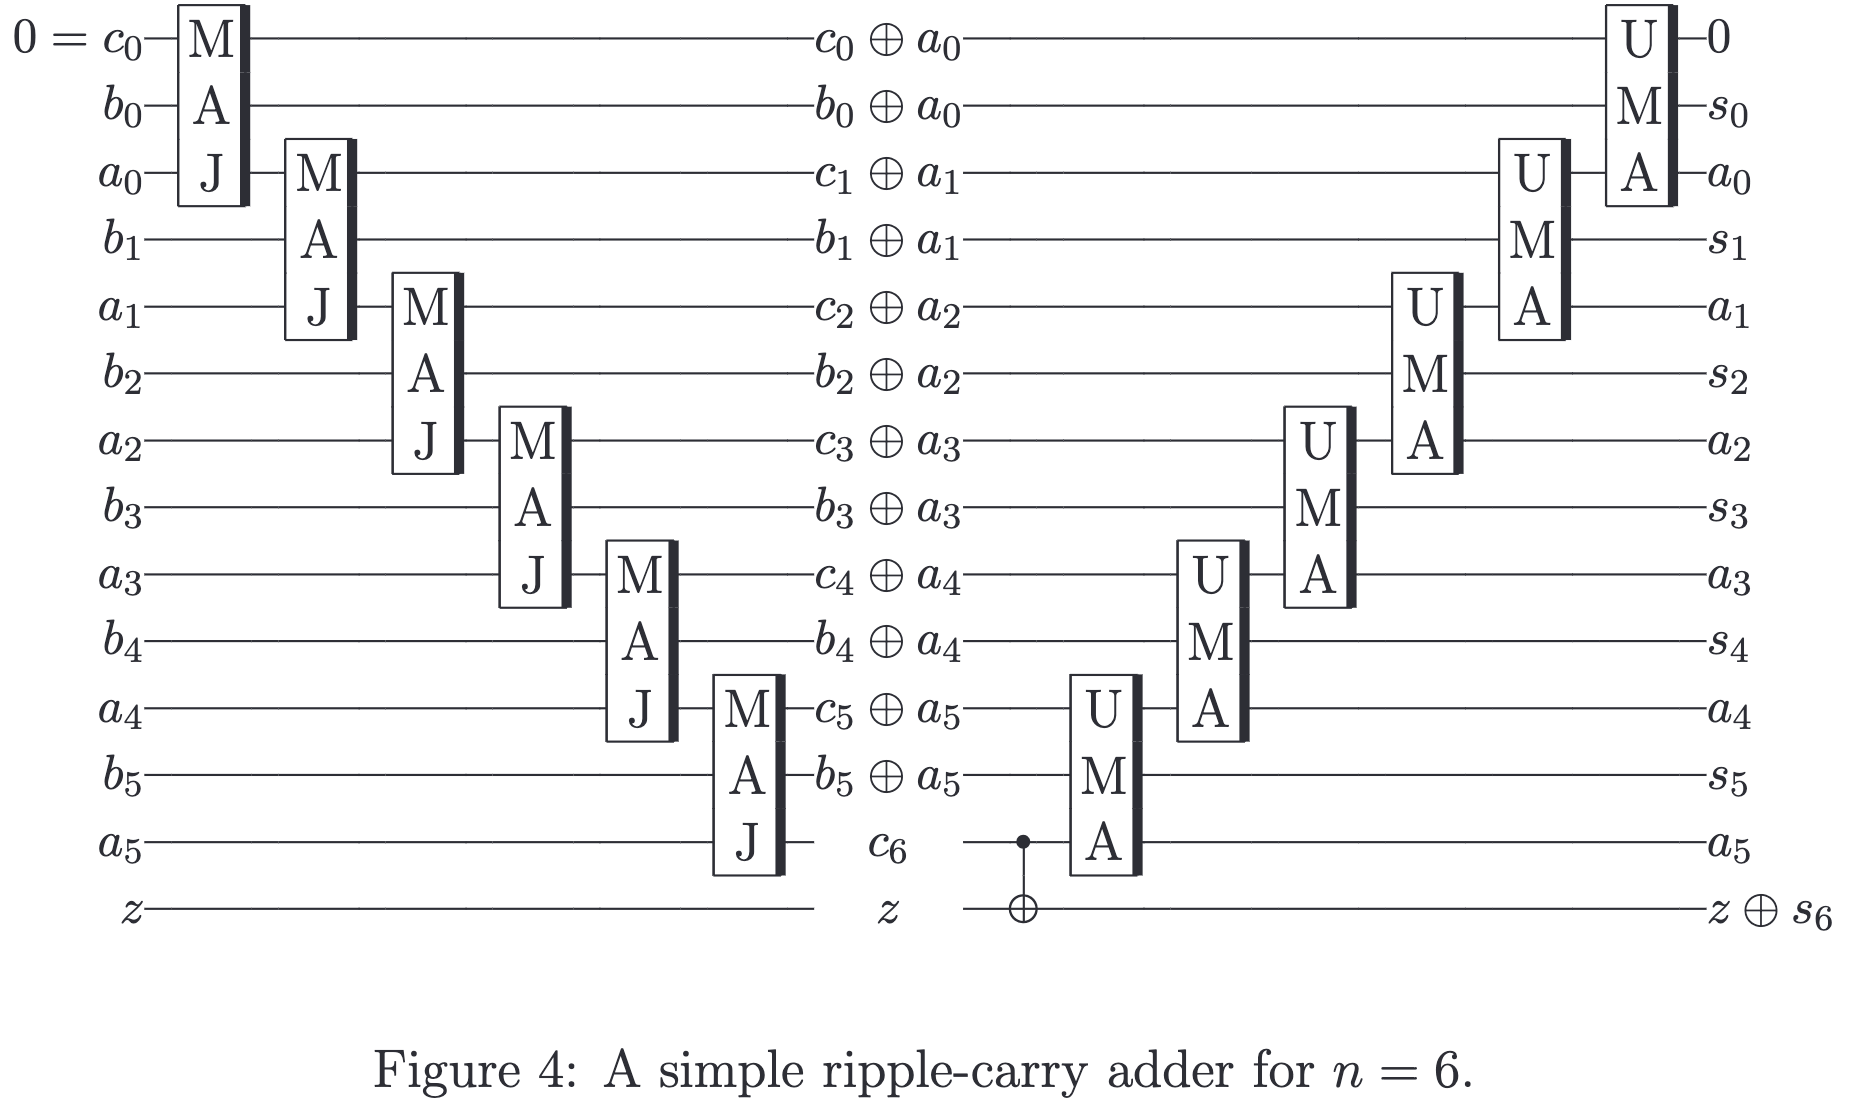

We will start by first implementing the $\text{MAJ}$ and $\text{UMA}$ primitives and then compose them to construct the adder.

#### References
 - [A new quantum ripple-carry addition circuit
](https://arxiv.org/abs/quant-ph/0410184). Figure 4.

## MAJ primitive


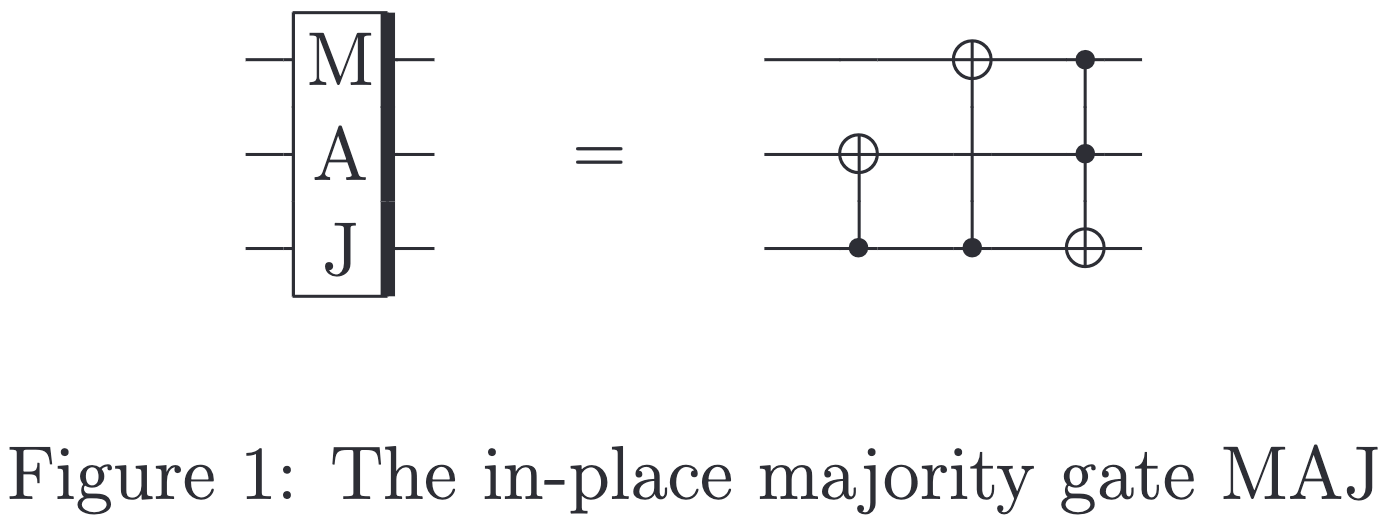


### Step-1: Implement the MAJ bloq with a signature
As a first step, implement a new bloq called `MAJ` that has the correct signature. Once you override the signature, you can already start using the Bloq as a primitive in higher level constructions. You can also draw a musical score representation of the Bloq, to visualize its inputs / output registers and their types, using `show_bloq(bloq, 'musical_score')`.

In [ ]:
from typing import Dict, Set
from functools import cached_property
from qualtran import Bloq, Signature, Register, QBit
from qualtran.bloqs.basic_gates import Toffoli, CNOT
from qualtran.drawing import show_bloq

class MAJ(Bloq):
    """Bloq the majority gate MAJ from Fig-1 of Ref[1].

    Registers:
       c: A 1-bit register representing a qubit for the carry bit (topmost wire).
       b: A 1-bit register representing a qubit for integer b (middle wire).
       a: A 1-bit register representing a qubit for integer a (bottom wire).

    References:
        [A new quantum ripple-carry addition circuit](https://arxiv.org/abs/quant-ph/0410184)
            see Fig.1
    """

    @cached_property
    def signature(self) -> Signature:
        # Exercise: Define the signature of the Bloq.
        # You can use the convenience builder method
        # `Signature.build_from_dtypes(reg1=Qubit(), reg2=Qubit() ... )`
        # Remember, the names and order of the registers will be important later.
        ...

show_bloq(MAJ(), 'musical_score')

### Step-2: Implement the `build_composite_bloq` method to specify the decomposition of MAJ bloq.

Once you have defined a barebone Bloq as done in Step-1, its useful to specify its decomposition in terms of other simpler bloqs. For MAJ, you can implement its decomposition in terms of `CNOT` and `TOFFOLI` gates. To do this in Qualtran, you'd override the `build_composite_bloq` method.

For bloqs which have a decomposition, you can get the decomposed Bloq via `bloq.decompose_bloq()`


In [ ]:
class MAJ(Bloq):
    """Bloq representing the majority gate MAJ from Fig-1 of Ref[1].

    Registers:
       c: A 1-bit register representing a qubit for the carry bit (topmost wire).
       b: A 1-bit register representing a qubit for integer b (middle wire).
       a: A 1-bit register representing a qubit for integer a (bottom wire).

    References:
        [A new quantum ripple-carry addition circuit](https://arxiv.org/abs/quant-ph/0410184)
            see Fig.1
    """

    @cached_property
    def signature(self) -> Signature:
        # Exercise: Copy from Step-1 above.
        # Define the signature of the Bloq.
        # You can use the convenience builder method
        # `Signature.build_from_dtypes(reg1=Qubit(), reg2=Qubit() ... )`
        # Remember, the names and order of the registers will be important later.
        ...

    def build_composite_bloq(
        self, bb: 'BloqBuilder', c: 'Soquet', b: 'Soquet', a: 'Soquet'
    ) -> Dict[str, 'Soquet']:
        # A BloqBuilder is used to construct a composite bloq (equivalent to
        # a circuit). In order to specify the decomposition of this Bloq, add
        # each gate in the decomposition one by one using `bb.add()` API.
        # As an example, we show how to add the first CNOT gate between wires
        # `a` --> `b`.
        a, b = bb.add(CNOT(), ctrl=a, target=b)
        ## Exercise: Add the remaining two CNOT and Toffoli bloqs via BloqBuilder.

        # In the end, we return a dictionary of soquets that correspond to the output
        # wires of this Bloq.
        return {'c':c, 'b':b, 'a':a}

# Since MAJ now has a decomposition, you should be able to print the circuit
# for the decomposed bloq.
show_bloq(MAJ().decompose_bloq(), 'musical_score')

## UMA primitive

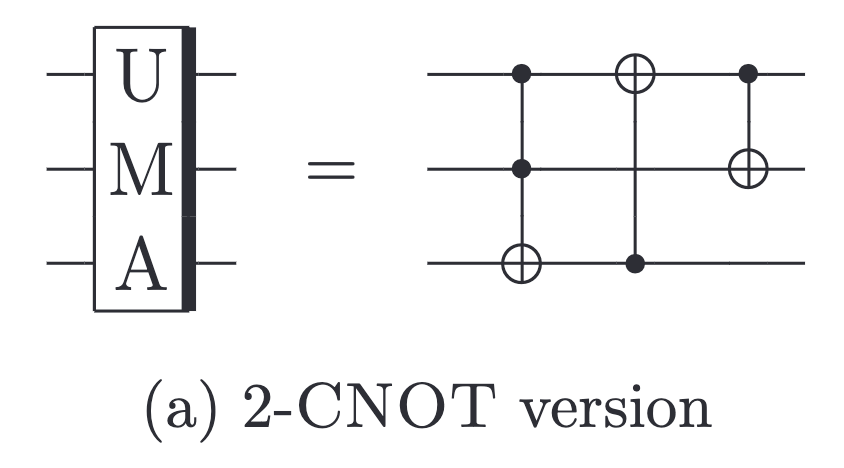

### Implement the UMA bloq by overriding the `signature` and `build_composite_bloq` methods.

In [ ]:
class UMA(Bloq):
    """Bloq representing the majority gate MAJ from Fig-1 of Ref[1].

    Registers:
       c: A 1-bit register representing a qubit for the carry bit (topmost wire).
       b: A 1-bit register representing a qubit for integer b (middle wire).
       a: A 1-bit register representing a qubit for integer a (bottom wire).

    References:
        [A new quantum ripple-carry addition circuit](https://arxiv.org/abs/quant-ph/0410184)
            see Fig.2 (a)
    """

    @cached_property
    def signature(self) -> Signature:
        # Exercise: Define the signature of the Bloq.
        ...

    def build_composite_bloq(
        self, bb: 'BloqBuilder', c: 'Soquet', b: 'Soquet', a: 'Soquet'
    ) -> Dict[str, 'SoquetT']:
        # Exercise: Define the decomposition of this Bloq as:
        #  - TOFFOLI(c, b, a)
        #  - CNOT(a, c)
        #  - CNOT(c, b)
        return {'c':c, 'b':b, 'a':a}

show_bloq(UMA(), 'musical_score')
show_bloq(UMA().decompose_bloq(), 'musical_score')

## Use MAJ and UMA to implement the n-bit Cuccaro adder



### Step-1: Implement just the call-graph via `build_call_graph`
In order to perform resource estimation quickly, we can simply the implement a Bloq with right signature and override the `build_call_graph` method to return the counts of each bloq that appear in the decomposition of the current Bloq. This would enable us to use the new bloq as a primitive in higher level algorithms and perform resource estimation, without requiring us to implement the exact circuit. This feature can be useful when you quickly want to implement the outline of an algorithm and don't care about circuit simulations.

In [ ]:
import attrs
from qualtran import QUInt
from qualtran.drawing import show_call_graph, show_counts_sigma

@attrs.frozen
class CuccaroAdder(Bloq):
    r"""n-bit Cuccaro adder for in-place quantum-quantum addition.

    Acts on registers $a$ and $b$ of size $n$ and $n + 1$ respectively and
    performs an in-place quantum quantum addition such that register $b$
    stores the output of $a + b$. Assumes that $b$ is large enough to
    store the output.

    $$
      \text{ADD}|a\rangle_{n} |b\rangle_{n+1} \rightarrow |a\rangle_{n} |a + b\rangle_{n+1}
    $$

    Args:
        bitsize: Size of the input register $a$ (=`n`) and $b$ (=`n+1)

    Registers:
      a: Input register of type QUInt(self.bitsize) and shape ().
      b: Input register of type QUInt(self.bitsize + 1) and shape ().

    References:
        [A new quantum ripple-carry addition circuit](https://arxiv.org/abs/quant-ph/0410184)
            see Fig.4
    """
    bitsize: int

    @cached_property
    def signature(self) -> Signature:
        a = Register('a', QUInt(self.bitsize))
        b = Register('b', QUInt(self.bitsize + 1))
        return Signature([a, b])

    def build_call_graph(self, ssa: 'SympySymbolAllocator') -> Set['BloqCountT']:
        # Exercise: Implement this method.

        # Return a set containing tuples of `(bloq, counts)` for every bloq
        # that occurs in the decomposition of the adder along with its counts
        # In this case, both the MAJ and UMA bloq occur `self.bitsize` times
        # and a CNOT bloq occurs 1 time.
        ...

adder = CuccaroAdder(10)
# A bloq with a signature has the right input / output wires and can be used as a primitive in a higher level bloq
show_bloq(adder)

In [ ]:
# Overriding the `build_call_graph` method should enable you to visualize the call graph do count up gates.
g, sigma = adder.call_graph()
show_call_graph(g)
show_counts_sigma(sigma)

In [ ]:
# Overriding `build_call_graph` also enables you to perform symbolic resource estimation.
import sympy

adder = CuccaroAdder(sympy.Symbol('n'))
g, sigma = adder.call_graph()
show_call_graph(g)
show_counts_sigma(sigma)

### Step-2: Implement the actual decomposition

We will copy the implementation of `CuccaroAdder` adder from the cell above and now override the `build_composite_bloq` method, where we now provide the exact circuit decomposition.

In [ ]:
@attrs.frozen
class CuccaroAdder(Bloq):
    r"""n-bit Cuccaro adder for in-place quantum-quantum addition.

    Acts on registers $a$ and $b$ of size $n$ and $n + 1$ respectively and
    performs an in-place quantum quantum addition such that register $b$
    stores the output of $a + b$. Assumes that $b$ is large enough to
    store the output.

    $$
      \text{ADD}|a\rangle_{n} |b\rangle_{n+1} \rightarrow |a\rangle_{n} |a + b\rangle_{n+1}
    $$

    Args:
        bitsize: Size of the input register $a$ (=`n`) and $b$ (=`n+1)

    Registers:
      a: Input register of type QUInt(self.bitsize) and shape ().
      b: Input register of type QUInt(self.bitsize + 1) and shape ().

    References:
        [A new quantum ripple-carry addition circuit](https://arxiv.org/abs/quant-ph/0410184)
            see Fig.4
    """
    bitsize: int

    @cached_property
    def signature(self) -> Signature:
        a = Register('a', QUInt(self.bitsize))
        b = Register('b', QUInt(self.bitsize + 1))
        return Signature([a, b])

    def build_call_graph(self, ssa: 'SympySymbolAllocator') -> Set['BloqCountT']:
        # Copy from Step-1

        # Return a set containing tuples of `(bloq, counts)` for every bloq
        # that occurs in the decomposition of the adder along with its counts
        # In this case, both the MAJ and UMA bloq occur `self.bitsize` times
        # and a CNOT bloq occurs 1 time.
        ...

    def build_composite_bloq(
        self, bb: 'BloqBuilder', a: 'Soquet', b: 'Soquet'
    ) -> Dict[str, 'SoquetT']:
        # Implement the `build_composite_bloq` method to specify the decomposition.
        n = self.bitsize
        # Split the n-bit and n+1-bit soquets for a and b into individual qubits.
        # Also reverse the ordering because by default we assume big-endianness.
        # `a` and `b` now are arrays of size `n` and `n+1` respectively, representing
        # the individual qubits in the decomposition.
        a, b = bb.split(a)[::-1], bb.split(b)[::-1]
        # Allocate a new clean ancilla qubit for the initial carry.
        c = bb.allocate(dtype=QBit())

        # Exercise: Add a ladder of MAJ gates

        # Exercise: Add a CNOT from a[n-1] -> b[n]

        # Exercise: Add a ladder of UMA gates in reverse order

        # Free the ancilla
        bb.free(c)
        # Join the soquets for a and b. Reverse before joining so we preserve the original order.
        a, b = bb.join(a[::-1]), bb.join(b[::-1])
        return {'a': a, 'b': b}



adder = CuccaroAdder(5)
cbloq = adder.decompose_bloq()
show_bloq(cbloq, 'musical_score')

In [ ]:
# Verify the that decomposition is actually correct by doing classical simulations,
# which you get for free since you have the decomposition specified.
for a in range(2**5):
    for b in range(2**5):
        assert adder.call_classically(a=a, b=b) == (a, a + b)

## Compare costs against the $n$-bit Gidney adder in Qualtran

Qualtran has an `Add` bloq implemented which implements the Gidney adder from Ref[2] below. The Gidney adder is a modification of the Cuccaro adder implemented above that uses $n$ ancilla qubits instead of $1$ and uses measuremenet based uncomputation to reduce the T-count to $4n$ instead of $8n$


#### References
 - [Halving the cost of quantum addition
](https://arxiv.org/abs/1709.06648). Figure 1.

In [ ]:
from qualtran.bloqs.arithmetic import Add

gidney_adder = Add(QUInt(sympy.Symbol('n')), QUInt(sympy.Symbol('n') + 1))
g, sigma = gidney_adder.call_graph()
show_call_graph(g)
show_counts_sigma(sigma)

In [ ]:
from qualtran.surface_code.algorithm_summary import AlgorithmSummary
cuccaro_adder = CuccaroAdder(100)
cuccaro_algo_summary = AlgorithmSummary.from_bloq(cuccaro_adder)
cuccaro_algo_summary

In [ ]:
from qualtran.bloqs.arithmetic import Add
gidney_adder = Add(QUInt(100), QUInt(101))
gidney_algo_summary = AlgorithmSummary.from_bloq(gidney_adder)
gidney_algo_summary